# Uso de docTR

# Instalación



## Instalación del paquete original



In [1]:
# Without gpu
!pip install "onnxtr[cpu]"
# With gpu
!pip install "onnxtr[gpu]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 KB 668.7 kB/s eta 0:00:00a 0:00:01
  Using cached onnxruntime-1.22.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.4 MB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl (46 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl (86 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 946.0 kB/s eta 0:00:0000:0100:09


## Intalación de mi versión

He hecho un fork del proyecto original para mejorar como se agrupan los bloques para obtener los parrafos correctos del texto

In [ ]:
# Install the most up-to-date version from GitHub

# TensorFlow
# !pip install python-doctr[tf,viz]@git+https://github.com/mindee/doctr.git

# PyTorch
# First we have to uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
# because the env variables USE_TORCH=1 / USE_TF=1 doesn't have an effect in Colab
# !pip uninstall -y tensorflow # Only if using Colab with PyTorch backend
!pip install python-doctr[torch,viz]@git+https://github.com/BlaiPuchol/doctr.git

# Dependencias

Algunas fuentes para la reconstrucción

In [3]:
# Install some free fonts for result rendering
!apt-get install fonts-freefont-ttf -y


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

from onnxtr.io import DocumentFile
from onnxtr.models import ocr_predictor

docTR ejecuta, en segundo plano, modelos de aprendizaje profundo para realizar las diferentes tareas que soporta. Cuenta con modelos con frameworks muy populares para lograr la máxima compatibilidad (se puede usar tanto con [PyTorch](https://pytorch.org/) o [TensorFlow](https://www.tensorflow.org/) sin notar ninguna diferencia). Se puede seleccionar tanto el modelo de detección como el modelo de reconocimiento. Todo esto se encapsula en un objeto `Predictor`, que se encargará del preprocesamiento, la inferencia del modelo y el posprocesamiento. 

In [87]:
# Instantiate a pretrained model
predictor = ocr_predictor('fast_base', # Text Detection
                          'crnn_vgg16_bn', # Text Recognition
                          det_bs=2, # detection batch size
                          reco_bs=512, # recognition batch size
                          # Document related parameters
                          assume_straight_pages=True,  # set to `False` if the pages are not straight (rotation, perspective, etc.) (default: True)
                          straighten_pages=False,  # set to `True` if the pages should be straightened before final processing (default: False)
                          export_as_straight_boxes=False,  # set to `True` if the boxes should be exported as if the pages were straight (default: False)
                          # Preprocessing related parameters
                          preserve_aspect_ratio=True,  # set to `False` if the aspect ratio should not be preserved (default: True)
                          symmetric_pad=True,  # set to `False` to disable symmetric padding (default: True)
                          # Additional parameters - meta information
                          detect_orientation=False,  # set to `True` if the orientation of the pages should be detected (default: False)
                          detect_language=False, # set to `True` if the language of the pages should be detected (default: False)
                          # Orientation specific parameters in combination with `assume_straight_pages=False` and/or `straighten_pages=True`
                          disable_crop_orientation=False,  # set to `True` if the crop orientation classification should be disabled (default: False)
                          disable_page_orientation=False,  # set to `True` if the general page orientation classification should be disabled (default: False)
                          # DocumentBuilder specific parameters
                          resolve_lines=True,  # whether words should be automatically grouped into lines (default: True)
                          resolve_blocks=False,  # whether lines should be automatically grouped into blocks (default: False)
                          paragraph_break=0.015,  # relative length of the minimum space separating paragraphs (default: 0.035)
                          ) #.cuda().half() # Use .cpu() if you don't have a GPU

Por defecto, el modelo de PyTorch proporciona una descripción visual clara del modelo, lo cual resulta útil para depurar o para saber qué se acaba de crear. También hay una función similar para el backend de TensorFlow para que no se pierda esta útil ayuda.

Profundicemos en este modelo 🕵

In [88]:
# Display the architecture
print(predictor)

OCRPredictor(
  (det_predictor): DetectionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(1024, 1024), interpolation='2', preserve_aspect_ratio=True, symmetric_pad=True)
      (normalize): Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))
    )
    (model): <onnxtr.models.detection.models.fast.FAST object at 0x76b5004b7160>
  )
  (reco_predictor): RecognitionPredictor()
  (doc_builder): DocumentBuilder(resolve_lines=True, resolve_blocks=False, paragraph_break=0.015, export_as_straight_boxes=False)
)


Aquí inspeccionamos el objeto más complejo (y de alto nivel) de la API de docTR: un predictor de OCR. Dado que docTR logra el OCR localizando primero los elementos textuales (Detección de Texto) y luego extrayendo el texto correspondiente de cada ubicación (Reconocimiento de Texto), el Predictor de OCR encapsula dos subpredictores: uno para la detección de texto y otro para el reconocimiento de texto.

## Inferencia básica

Seleccionamos el archivo a extraer el texto. Puede ser tanto una imagen como un documento.

In [89]:
# Read the file
doc = DocumentFile.from_images("example4.png")
print(f"Number of pages: {len(doc)}")

Number of pages: 1


Y procesamos el archivo

In [90]:
result = predictor(doc)

## Visualización de la predicción

Los datos obtenidos se pueden visualizar de muchas formas:

### En la propia imagen

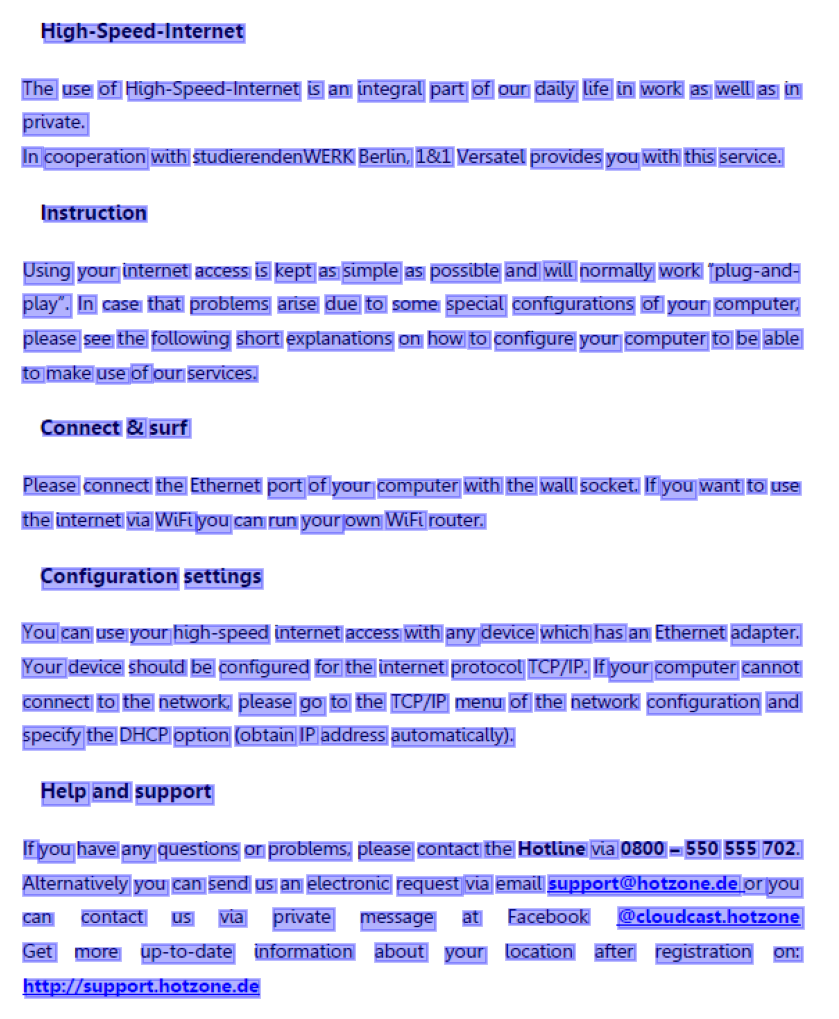

In [91]:
result.show()

Además, si el texto se ha reconocido correctamente, se puede generar el mismo documento:

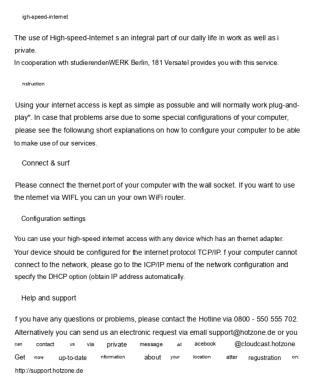

In [92]:
synthetic_pages = result.synthesize(font_family='arial.ttf')  
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()

### Visualización del objeto

Aqui se puede ver como las palabras se han organizado en lineas y estas en bloques, que deberian corresponder a los párrafos en un texto.

In [93]:
print(result)

Document(
  (pages): [Page(
    dimensions=(721, 591)
    (blocks): [Block(
      (lines): [
        Line(
          (words): [Word(value='igh-speed-internet', confidence=0.65)]
        ),
        Line(
          (words): [
            Word(value='The', confidence=1.0),
            Word(value='use', confidence=0.98),
            Word(value='of', confidence=1.0),
            Word(value='High-speed-Internet', confidence=0.7),
            Word(value='s', confidence=0.62),
            Word(value='an', confidence=1.0),
            Word(value='integral', confidence=0.98),
            Word(value='part', confidence=1.0),
            Word(value='of', confidence=1.0),
            Word(value='our', confidence=0.97),
            Word(value='dally', confidence=0.58),
            Word(value='life', confidence=1.0),
            Word(value='in', confidence=0.89),
            Word(value='work', confidence=0.97),
            Word(value='as', confidence=1.0),
            Word(value='well', confidence=0.9

## Exportar los resultados

Estos datos se pueden exportar tanto en JSON como en texto plano:

In [94]:
# JSON export
json_export = result.export()
print(json_export)

{'pages': [{'page_idx': 0, 'dimensions': (721, 591), 'orientation': {'value': None, 'confidence': None}, 'language': {'value': None, 'confidence': None}, 'blocks': [{'geometry': ((np.float64(0.013919733502538056), np.float64(0.0146484375)), (np.float64(0.9670182952622673), np.float64(0.9873046875))), 'objectness_score': 0.7734195026337292, 'lines': [{'geometry': ((np.float64(0.04012994395093061), np.float64(0.0146484375)), (np.float64(0.2843614504018612), np.float64(0.0322265625))), 'objectness_score': 0.8202422857284546, 'words': [{'value': 'igh-speed-internet', 'confidence': 0.6462898651758829, 'geometry': ((np.float64(0.04012994395093061), np.float64(0.0146484375)), (np.float64(0.2843614504018612), np.float64(0.0322265625))), 'objectness_score': 0.8202422857284546, 'crop_orientation': {'value': 0, 'confidence': None}}]}, {'geometry': ((np.float64(0.013919733502538056), np.float64(0.0693359375)), (np.float64(0.964635548857868), np.float64(0.091796875))), 'objectness_score': 0.7682839

O en texto plano:

In [95]:
# Render the result to a string
string_result = result.render()
print(string_result)

igh-speed-internet
The use of High-speed-Internet s an integral part of our dally life in work as well as i
private.
In cooperation wth studierendenWERK Berlin, 181 Versatel provides you with this service.
nstruction
Using your internet access is kept as simple as possuble and will normally work plug-and-
play". In case that problems arse due to some special configurations of your computer,
please see the followung short explanations on how to configure your computer to be able
to make use of our services.
Connect & surf
Please connect the thernet port of your computer with the wall socket. If you want to use
the nternet via WIFL you can un your own WiFi router.
Configuration settings
You can use your high-speed internet access with any device which has an thernet adapter.
Your device should be configured for the internet protocol TCP/IP. f your computer cannot
connect to the network, please go to the ICP/IP menu of the network configuration and
specify the DHCP option (obtain IP addre